In [1]:
import os
import pandas as pd
from music21 import converter, note, chord, stream
from pandas_parallel_apply import DataFrameParallel, SeriesParallel
import warnings
warnings.filterwarnings('ignore')

In [2]:
DATA_PATH = 'data/MidiCaps/'

In [3]:
df = pd.read_json(DATA_PATH + 'train3.json', lines=True)

In [4]:
df.head()

,location,caption,genre,genre_prob,mood,mood_prob,key,time_signature,tempo,tempo_word,...,instrument_summary,instrument_numbers_sorted,all_chords,all_chords_timestamps,test_set,num_tracks,num_time_signatures,num_instruments,instruments,initial_silence
0,lmd_full/1/16b9a230fb007c0009feee532c3c4686.mid,This energetic electronic and classical compos...,"[electronic, classical]","[0.21480000000000002, 0.1806]","[energetic, film, melodic, happy, dark]","[0.10790000000000001, 0.1062, 0.09580000000000...",C major,4/4,120,Moderate tempo,...,[],[],"[C, G, C, C7, Dm, C, G, C, C7, Bbmaj7, C, G7, ...","[0.464399092, 4.086712018, 7.430385487, 8.9164...",False,1,1,1,[None],1
1,lmd_full/1/17655598958db48a34cd882f81402568.mid,A short electronic ambient song featuring a pi...,"[electronic, ambient]","[0.30310000000000004, 0.2369]","[film, energetic, melodic, epic, dark]","[0.11620000000000001, 0.11080000000000001, 0.1...",E major,4/4,170,Presto,...,[Piano],[0],"[B, Emaj7, C#m7, B7, A, B, Emaj7, C#m7, B7, A,...","[0.464399092, 1.30031746, 2.972154195, 3.71519...",False,1,1,1,[Piano],0
2,lmd_full/1/180b3a492c1c1a46d005e762d62b9aa4.mid,A cheerful pop song with a touch of electronic...,"[pop, electronic]","[0.4238, 0.2548]","[happy, love, melodic, christmas, motivational]","[0.1521, 0.09870000000000001, 0.0935, 0.0737, ...",D major,4/4,96,Moderate tempo,...,"[Piano, Drums]","[0, 0, 0, 128, 0]","[D, A7, D, Em, A, D, Em7, A7, D, Em7, A7, D, G...","[0.464399092, 7.616145124, 9.938140589, 12.353...",False,5,1,5,"[bass, Piano, guitar, Percussion, strings]",3
3,lmd_full/1/1f94f64f72af98fd92f206293b281f6f.mid,A classical piece that could be part of a film...,"[classical, soundtrack]","[0.6144000000000001, 0.225]","[film, relaxing, emotional, documentary, drama]","[0.16640000000000002, 0.1048, 0.0655, 0.0621, ...",C# major,4/4,74,Andante,...,[Recorder],[74],"[C#, Fm, Ab, C#, Fm, Bbm, C, Bbm, B, Bb, Ab, F...","[0.464399092, 1.764716553, 9.752380952, 11.609...",False,2,1,1,[Recorder],0
4,lmd_full/1/112139e8b17be9cae1bd14df56e52f14.mid,A short fragment of energetic electronic and c...,"[electronic, classical]","[0.32370000000000004, 0.30610000000000004]","[energetic, film, dark, epic, action]","[0.1081, 0.1009, 0.0961, 0.0916, 0.0896]",F major,4/4,136,Allegro,...,[Piano],"[0, 0]","[A, F/A]","[0.464399092, 1.671836734]",False,2,1,2,"[intro bass (MIDI), Piano]",0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40593 entries, 0 to 40592
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   location                   40593 non-null  object
 1   caption                    40593 non-null  object
 2   genre                      40593 non-null  object
 3   genre_prob                 40593 non-null  object
 4   mood                       40593 non-null  object
 5   mood_prob                  40593 non-null  object
 6   key                        40593 non-null  object
 7   time_signature             40593 non-null  object
 8   tempo                      40593 non-null  int64 
 9   tempo_word                 40593 non-null  object
 10  duration                   40593 non-null  int64 
 11  duration_word              40593 non-null  object
 12  chord_summary              40593 non-null  object
 13  chord_summary_occurence    40593 non-null  int64 
 14  instru

In [24]:
len(df[df['initial_silence'] < 5])

37014

In [6]:



def analyze_dataset(df, n_track=4, n_silence=4):
    # count number of single time signature
    time_signature_filtered = len(df[df['num_time_signatures'] == 1])
    track_num_filtered = len(df[df['num_tracks'] < n_track ])
    silence_filtered = len(df[df['initial_silence'] < n_silence])

    combined_filter = df[(df['num_time_signatures'] == 1) & (df['num_tracks'] < n_track) & (df['initial_silence'] < n_silence)].copy()
    # filter empty instrument
    inst_filter = combined_filter[combined_filter['instrument_summary'].apply(lambda x: len(x) > 0)]

    print(f"Number of samples with single time signature: {time_signature_filtered}")
    print(f"Number of samples with track number smaller than {n_track}: {track_num_filtered}")
    print(f"Number of samples with initial silence notes smaller than {n_silence}: {silence_filtered}")
    print(f"Number of samples with combined criteria: {len(inst_filter)}")

    # count the number of samples with different track to instruments
    track_filter = inst_filter[inst_filter['num_instruments'] > inst_filter['num_tracks']]

    print(f"Number of samples with instruments number less than track: {len(track_filter)}")
    

    return track_filter





def get_exception_silent_notes(df, n=4):
    """
    Get the exception silent notes from the dataframe.
    :param df: DataFrame
    :param n: number of silent notes
    :return: DataFrame
    """
    df_exp = df[df['initial_silence'] == n].copy()
    sample = df_exp.sample(n=1)
    return sample['location'].values[0]

In [7]:
df_filtered = analyze_dataset(df, n_track=6, n_silence=5)

Number of samples with single time signature: 34078
Number of samples with track number smaller than 6: 37652
Number of samples with initial silence notes smaller than 5: 37014
Number of samples with combined criteria: 22387
Number of samples with instruments number less than track: 6165


In [19]:
get_exception_silent_notes(df, n=5)

'lmd_full/3/31a91b8f53c670efc2675d7efd3f79f9.mid'

Create a filtered dataset:
* Max initial silences notes 4
* Single time signature
* Max number of tracks 4

In [50]:
type(df_filtered.iloc[0].instruments[0])

NoneType

In [9]:
df_filtered.sample(5)

,location,caption,genre,genre_prob,mood,mood_prob,key,time_signature,tempo,tempo_word,...,instrument_summary,instrument_numbers_sorted,all_chords,all_chords_timestamps,test_set,num_tracks,num_time_signatures,num_instruments,instruments,initial_silence
1702,lmd_full/1/154015512ef6190561dffaebfbf02115.mid,A relaxing classical piece featuring an acoust...,"[classical, pop]","[0.4378, 0.155]","[relaxing, meditative, inspiring, happy, love]","[0.157, 0.1189, 0.1187, 0.1134, 0.104000000000...",A minor,3/4,100,Moderate tempo,...,[Acoustic Guitar],"[24, 24]","[Am, Dm, C#m, Gm, Am6, Fm, F7/A, Am7b5, Am, F7...","[0.464399092, 3.529433106, 5.479909297, 6.8731...",False,2,1,3,"[Guitar 1, Acoustic Guitar, Guitar 2]",0
11658,lmd_full/f/f45e3a63581c67c18af0a5fe69dbb1c1.mid,A dark and melodic rock song with electronic e...,"[rock, electronic]","[0.27, 0.2247]","[dark, melodic, film, relaxing, epic]","[0.1182, 0.0971, 0.0927, 0.0849, 0.0833]",E minor,4/4,300,Prestissimo,...,"[Electric Piano, Piano]","[2, 0, 2, 0, 2, 1]","[E7, Ebmaj7, C, Dmaj7, Ebmaj7, E7, B, E, Em7b5...","[2.507755102, 11.238458049, 11.981496598, 16.2...",False,1,1,2,"[Electric Piano, Piano]",2
18295,lmd_full/7/7689b668f3ab1b1eb34f91e1531a71e9.mid,"A short, fast-paced fragment of classical and ...","[classical, electronic]","[0.2204, 0.2069]","[film, dark, melodic, relaxing, emotional]","[0.1203, 0.1124, 0.0889, 0.0834, 0.0751]",C# minor,4/4,140,Fast,...,[Piano],[0],"[Abm, Ab, F#]","[0.464399092, 2.136235827, 6.780226757]",False,2,1,3,"[guitar (MIDI), Acoustic Guitar, Electric Bass]",0
10599,lmd_full/f/f8335838267d424b577a5241884fa4e1.mid,"A relaxing pop song with classical influences,...","[pop, classical]","[0.35550000000000004, 0.26940000000000003]","[relaxing, love, emotional, happy, inspiring]","[0.1506, 0.14100000000000001, 0.12490000000000...",F major,4/4,120,Moderate tempo,...,"[Piano, Acoustic Guitar]","[1, 24, 25, 24]","[F, Bb, C, F, Bb, C7, F, Bb, C, F, Bb, C, Bb, ...","[0.464399092, 0.9287981850000001, 1.671836734,...",False,1,1,3,"[Acoustic Guitar, Piano, Guantananera]",0
18125,lmd_full/7/7e1ea09db92d801dd558094eb93907a5.mid,A relaxing electronic ambient song with a synt...,"[electronic, ambient]","[0.4449, 0.2639]","[relaxing, space, meditative, dream, dark]","[0.1381, 0.1232, 0.1102, 0.1027, 0.101]",E minor,4/4,120,Moderate tempo,...,[Synth Lead],[86],"[G/D, Em7, E/B, Gmaj7, G/D, Em, G, G/D, Em7, G...","[0.464399092, 13.374693877, 22.476916099, 23.6...",False,1,1,3,"[Track 1, Sampler, Piano]",4


In [91]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16222 entries, 1 to 40587
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   location                   16222 non-null  object
 1   caption                    16222 non-null  object
 2   genre                      16222 non-null  object
 3   genre_prob                 16222 non-null  object
 4   mood                       16222 non-null  object
 5   mood_prob                  16222 non-null  object
 6   key                        16222 non-null  object
 7   time_signature             16222 non-null  object
 8   tempo                      16222 non-null  int64 
 9   tempo_word                 16222 non-null  object
 10  duration                   16222 non-null  int64 
 11  duration_word              16222 non-null  object
 12  chord_summary              16222 non-null  object
 13  chord_summary_occurence    16222 non-null  int64 
 14  instrument_

In [92]:
df_filtered.to_json('data/MidiCaps/train_filtered.json', lines=True, orient='records')

<Axes: >

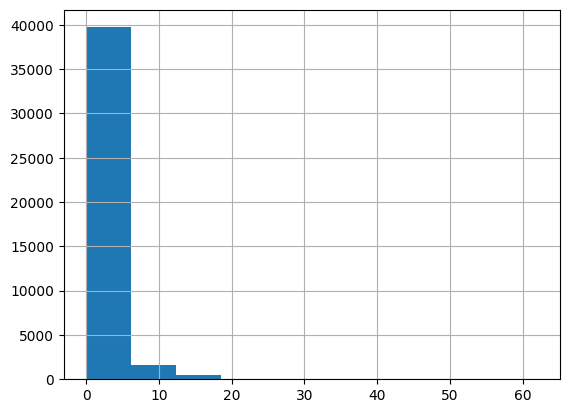

In [ ]:
df.num_tracks.hist()

In [9]:
len(df[df.num_tracks < 5])

36685

<Axes: >

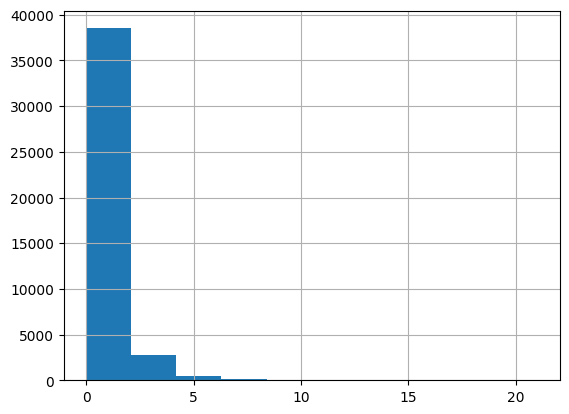

In [8]:
df.num_time_signatures.hist()

In [13]:
len(df[df.num_time_signatures > 1])

2213